# ISIDORA

When a man rides a long time through wild regions he feels the desire for a city. Finally he comes to Isidora, a city where the buildings have spiral staircases encrusted with spiral seashells, where perfect telescopes and violins are made, where the foreigner hesitating between two women always encounters a third, where cockfights degenerate into bloody brawls among the bettors. He was thinking of all these things when he desired a city. Isidora, therefore, is the city of his dreams: with one difference. The dreamed-of city contained him as a young man; he arrives at Isidora in his old age. In the square there is the wall where the old men sit and watch the young go by; he is seated in a row with them. Desires are already memories.

In [1]:
from __future__ import print_function
from IPython.display import Image
%matplotlib inline

In [2]:
ic = %env ICDIR

In [3]:
ic

'/Users/jjgomezcadenas/Documents/Development/NEXT/IC'

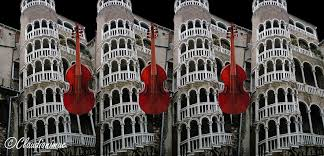

In [4]:
Image(filename=ic+'/Images/Isidora.jpg') 

In [5]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [6]:
import pandas as pd
import tables as tb
import numpy as np
import tables

In [7]:
from system_of_units import *

In [8]:
from PlotUtil import *
from Util import *

In [9]:
import FEParam as FP
import SPE as SP
import FEE2 as FE
from scipy import signal as SGN 

In [10]:
from Configure import configure
from cities import isidora

### BLR

#### Deconvolution function

In [39]:
class SBLR:
    """
    Signals BLR: a simple class to hold of the signals relevant for BLR
    """
    def __init__(self, len_signal_daq):
        """
        len_signal_daq: length of the signal to deconvolute
        
        
        """
        
        self.MAU = np.zeros(len_signal_daq, dtype=np.double)
        self.acum = np.zeros(len_signal_daq, dtype=np.double)
        self.signal_r = np.zeros(len_signal_daq, dtype=np.double)
        self.pulse_on = np.zeros(len_signal_daq, dtype=np.double)
        self.wait_over = np.zeros(len_signal_daq, dtype=np.double)
        self.offset = np.zeros(len_signal_daq, dtype=np.double)
        self.BASELINE = 0
        

def BLR(signal_daq, coef, mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = FP.NOISE_ADC, 
        thr3 = FP.NOISE_ADC, log='INFO'):

    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data. See notebook 
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    
    lg = 'logging.'+log
    logger.setLevel(eval(lg))
    len_signal_daq = len(signal_daq)
    sblr = SBLR(len_signal_daq)

    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    sblr.acum[nm] =  sblr.MAU[nm]
    sblr.BASELINE = sblr.MAU[nm-1]

    logging.debug("""-->BLR: 
                     MAU_LEN={}
                     thr1 = {}, thr2 = {}, thr3 = {} =""".format(
                     mau_len, thr1, thr2, thr3))
    logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, sblr.acum[nm],sblr.BASELINE))

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    sblr.signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0
    
    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    logging.debug("nm = {}".format(nm))
    
    for k in range(nm,len_signal_daq): 

        trigger_line = sblr.MAU[k-1] + thr1
        sblr.pulse_on[k] = pulse_on
        sblr.wait_over[k] = wait_over 
        sblr.offset[k] = offset
        
        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = sblr.MAU[k-1]  
                pulse_on = 1 
                
            #Pulse is on: Freeze the MAU
            sblr.MAU[k] = sblr.MAU[k-1]  
            signal_i[k] = sblr.MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
            sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                  
            
        else:  #no signal or raw signal has dropped below threshold
                      
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
                # switch the pulse off only when recovered signal 
                #drops below threshold
                #slide the MAU, still frozen. 
                # keep recovering signal
                
                sblr.MAU[k] = sblr.MAU[k-1] 
                signal_i[k] = sblr.MAU[k-1]
                sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
                sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if sblr.signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over
                      

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse
                        
                    if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
                        # raw signal still below recovered signal 
                        # keep compensating pulse
                        # is the recovered signal near offset?
                        upper = offset + (thr3 + thr2)
                        lower = offset - (thr3 + thr2)
                        
                        if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            
                            signal_i[k] = sblr.signal_r[k-1]
                            sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
                        else: 
                            # rec signal not near offset MAU frozen  
                            sblr.MAU[k] = sblr.MAU[k-1]
                            signal_i[k] = sblr.MAU[k-1]
                            
                        # keep adding recovered signal  
                        sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
                        sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
                    else:  # raw signal above recovered signal: we are done 
                        
                        wait_over = 0
                        sblr.acum[k] = sblr.MAU[k-1]
                        sblr.signal_r[k] = signal_daq[k]
                        signal_i[k] = sblr.signal_r[k]
                        sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                        
                            
                else: #signal still not found
                    
                    #update MAU and signals
                    sblr.MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm   
                    sblr.acum[k] = sblr.MAU[k-1]
                    sblr.signal_r[k] = signal_daq[k]
                    signal_i[k] = sblr.signal_r[k]  
                                                                                                       
    #energy = np.dot(pulse_f,(signal_r-BASELINE)) 
    
    logging.debug("sblr.signal_r[0:10]= {}".format(sblr.signal_r[0:10]))
    logging.debug("BASELINE ={}".format(sblr.BASELINE))
                       
    sblr.signal_r = sblr.signal_r - sblr.BASELINE
    
    logging.debug("sblr.signal_r[0:10] - BASELINE= {}".format(sblr.signal_r[0:10]))
   
    return  sblr

def accumulator_coefficients(pmtrd,CA):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    coef_acc =np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        coef_acc[j] = signal_inv_daq[10] #any index is valid, function is flat
        
    return coef_acc

def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=FP.NOISE_ADC, thr3 = FP.NOISE_ADC, log='INFO'):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """
    
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    BLRS =[]
    for j in range(NPMT):
        sblr = BLR(pmtrd[event_number, j], coeff_acc[j], mau_len, thr1, thr2, thr3, log)
        BLRS.append(sblr)
       
    return BLRS


### ISIDORA

In [40]:
def ISIDORA(argv):
    DEBUG_LEVEL, INFO, CFP = configure(argv[0],argv[1:])
    if INFO:
        print(isidora)

    #wait()
    
    print("""
        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST 

        4. Computes the energy of the PMTs per each event and writes to DST

        """)

    
    PATH_IN=CFP['PATH_IN'] 
    FILE_IN=CFP['FILE_IN']
    FIRST_EVT=CFP['FIRST_EVT']
    LAST_EVT=CFP['LAST_EVT']
    RUN_ALL=CFP['RUN_ALL']
    COEF=CFP['COEF']
    CA=farray_from_string(CFP['CA'])*nF 
    AC=farray_from_string(CFP['AC']) 
    MAU_LEN=CFP['MAU_LEN']
    NSIGMA1=CFP['NSIGMA1'] 
    NSIGMA2=CFP['NSIGMA2'] 
    NSIGMA3=CFP['NSIGMA3'] 

    NEVENTS = LAST_EVT -  FIRST_EVT

    print('Debug level = {}'.format(DEBUG_LEVEL))

    logger.info("input path ={}; file_in ={} ".format(
        PATH_IN,FILE_IN))

    logger.info("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    logger.info("MAU length = {} n_sigma1 = {} n_sigma2 = {} n_sigma3 = {} ".format(
        MAU_LEN,NSIGMA1,NSIGMA2, NSIGMA3))
    logger.info("CA sigma(nf) = {}  ".format(CA/nF))
    

    # open the input file in mode append 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "a") as h5in: 
        # access the PMT raw data in file 
        pmtrd_ = h5in.root.RD.pmtrwf

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)    
        
        NPMT = pmtrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        NEVENTS_DST = pmtrd_.shape[0]

        logger.info("nof PMTs = {} nof events in input DST = {} ".format(
        NPMT,NEVENTS_DST))

        logger.info("lof PMT WF (MC) = {} ".format(
        PMTWL))

        #wait()
            
        # create an extensible array to store the CWF waveforms
        # if it exists remove and create again
        pmtcwf =0
        try:
            pmtcwf = h5in.root.RD.pmtcwf
            h5in.remove_node("/RD","pmtcwf")
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL), 
                                    expectedrows=NEVENTS_DST)

        # create a group to store BLR configuration (por PMT0)

        rgroup = 0
        try:
            rgroup = h5in.root.BLR
            
        except tables.exceptions.NodeError:
            rgroup = h5in.create_group(h5in.root, "BLR")

        
        mau = 0
        acum = 0
        pulse_on = 0
        wait_over = 0
        baseline = 0

        try:
            mau = h5in.root.BLR.mau
            h5in.remove_node("/BLR","mau")
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            mau = h5in.create_earray(h5in.root.BLR, "mau", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            pulse_on = h5in.root.BLR.pulse_on
            h5in.remove_node("/BLR","pulse_on")
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            wait_over = h5in.root.BLR.wait_over
            h5in.remove_node("/BLR","wait_over")
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            wait_over = h5in.create_earray(h5in.root.BLR, "wait_over", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            acum  = h5in.root.BLR.acum 
            h5in.remove_node("/BLR","acum")
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            acum  = h5in.create_earray(h5in.root.BLR, "acum", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, PMTWL), 
                                    expectedrows=NEVENTS_DST)
        try:
            baseline  = h5in.root.BLR.baseline 
            h5in.remove_node("/BLR","baseline")
            baseline  = h5in.create_earray(h5in.root.BLR, "baseline", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT), 
                                    expectedrows=NEVENTS_DST)
        except tables.exceptions.NodeError:
            baseline  = h5in.create_earray(h5in.root.BLR, "baseline", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT), 
                                    expectedrows=NEVENTS_DST)

            
        if NEVENTS > NEVENTS_DST and RUN_ALL == False:
            print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
            sys.exit(0)

        elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
            FIRST_EVT = 0
            LAST_EVT = NEVENTS_DST
            NEVENTS = NEVENTS_DST

            
        for i in range(FIRST_EVT,LAST_EVT):
            
            logger.info("-->event number ={}".format(i))

            #DBLR
            coeff_acc = AC
            if COEF == 0:
                coeff_acc = accumulator_coefficients(pmtrd_,CA)


            BLRS = DBLR(pmtrd_, i, coeff_acc, mau_len=MAU_LEN,
                        thr1 = NSIGMA1*FP.NOISE_ADC, thr2=NSIGMA1*FP.NOISE_ADC, 
                        thr3 = NSIGMA3*FP.NOISE_ADC, log=DEBUG_LEVEL)

            
            pmtCWF = []
            for blr in BLRS:
                pmtCWF.append(blr.signal_r)
                
            #append to pmtcwd
            pmtcwf.append(np.array(pmtCWF).reshape(1, NPMT, PMTWL))

            # append BLR variables
            
            
            BASELINE = []
            for blr in BLRS:
                BASELINE.append(blr.BASELINE)
            baseline.append(np.array(BASELINE).reshape(1, NPMT))

            mau_pmt0 = BLRS[0].MAU
            mau.append(mau_pmt0.reshape(1, PMTWL))

            pulse_on0 = BLRS[0].pulse_on
            pulse_on.append(pulse_on0.reshape(1, PMTWL))

            wait_over0 = BLRS[0].wait_over
            wait_over.append(wait_over0.reshape(1, PMTWL))

            acum0  = BLRS[0].acum
            acum.append(acum0.reshape(1, PMTWL))
                
                
        pmtcwf.flush()
        mau.flush()
        pulse_on.flush()
        wait_over.flush()
        acum.flush()
        baseline.flush()
        

    print("Leaving Isidora. Safe travels!")


### Tuning the deconv parameters

#### thr1 = 3 x sigma, thr2 = 1 x sigma, thr3 = 1 xsigma

In [113]:
%less ../../Config/ISIDORA_NA_ZLIB_test2.csv

In [42]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+") 

In [115]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/BLR (Group) ''
/BLR/acum (EArray(10, 24000), shuffle, zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 16384)
/BLR/baseline (EArray(10, 12), shuffle, zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1365, 12)
/BLR/mau (EArray(10, 24000), shuffle, zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 16384)
/BLR/pulse_on (EArray(10, 24000), shuffle, zlib(1)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 163

In [15]:
pmtrwf = h5f.root.RD.pmtrwf

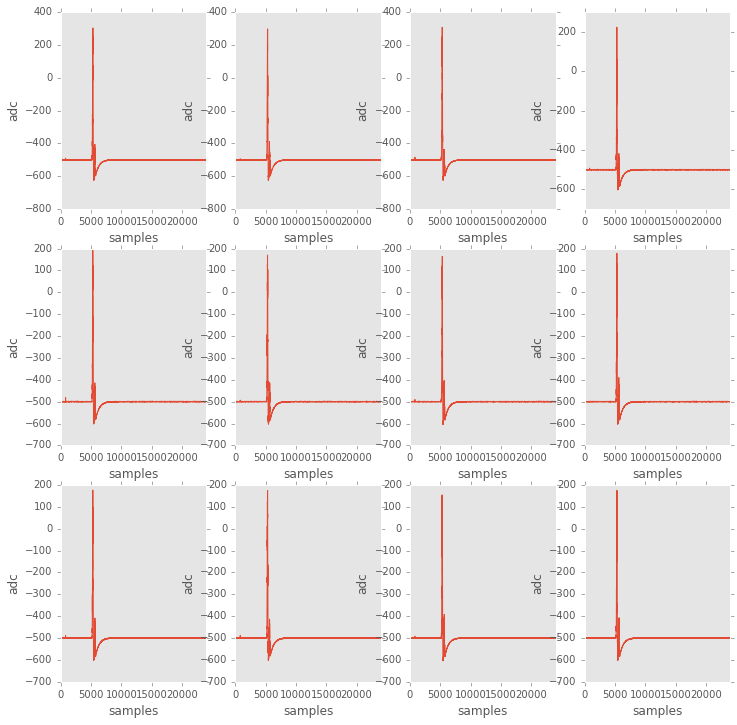

In [16]:
plot_waveforms(pmtrwf[0]) 

In [43]:
h5f.close()

In [114]:
ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

INFO:root:Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'AC': '0.0017643 0.00170883 0.00175343 0.0017099 0.00168862 0.00174429 0.0017206 0.00171095 0.00171778 0.00168723 0.00171486 0.00168533', 'LAST_EVT': 10, 'COEF': 1, 'CA': '6.02975448 6.22547194 6.0671337 6.22159457 6.29999787 6.09892384 6.18289435 6.21775591 6.19306671 6.30518792 6.20359891 6.312311921', 'MAU_LEN': 250, 'END ': 1, 'NSIGMA2': 1.0, 'NSIGMA3': 1.0, 'NSIGMA1': 3.0, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'FILE_IN': 'WF_Na_ZLIB_offset500_RWF.h5'}


Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'AC': '0.0017643 0.00170883 0.00175343 0.0017099 0.00168862 0.00174429 0.0017206 0.00171095 0.00171778 0.00168723 0.00171486 0.00168533', 'LAST_EVT': 10, 'COEF': 1, 'CA': '6.02975448 6.22547194 6.0671337 6.22159457 6.29999787 6.09892384 6.18289435 6.21775591 6.19306671 6.30518792 6.20359891 6.312311921', 'MAU_LEN': 250, 'END ': 1, 'NSIGMA2': 1.0, 'NSIGMA3': 1.0, 'NSIGMA1': 3.0, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'FILE_IN': 'WF_Na_ZLIB_offset500_RWF.h5'}



        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST 

        4. Computes the energy of the PMTs per each event and writes to DST

        
Debug level = INFO
INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_offset500_RWF.h5 


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_offset500_RWF.h5 


INFO:root:first event = 0 last event = 10 nof events requested = 10 


first event = 0 last event = 10 nof events requested = 10 


INFO:root:MAU length = 250 n_sigma1 = 3.0 n_sigma2 = 1.0 n_sigma3 = 1.0 


MAU length = 250 n_sigma1 = 3.0 n_sigma2 = 1.0 n_sigma3 = 1.0 


INFO:root:CA sigma(nf) = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192]  


CA sigma(nf) = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192]  


INFO:root:nof PMTs = 12 nof events in input DST = 10 


nof PMTs = 12 nof events in input DST = 10 


INFO:root:lof PMT WF (MC) = 24000 


lof PMT WF (MC) = 24000 


INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


Leaving Isidora. Safe travels!


In [45]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+") 

In [46]:
pmtrwf = h5f.root.RD.pmtrwf
pmttwf = h5f.root.RD.pmttwf
pmtcwf = h5f.root.RD.pmtcwf

In [47]:
epmt = h5f.root.RD.epmt

In [48]:
CA = FP.C12

In [49]:
CA/nF

array([ 6.02975448,  6.22547194,  6.0671337 ,  6.22159457,  6.29999787,
        6.09892384,  6.18289435,  6.21775591,  6.19306671,  6.30518792,
        6.20359891,  6.31231192])

In [50]:
coef = accumulator_coefficients(pmtrwf,CA)

In [51]:
coef

array([ 0.0017643 ,  0.00170883,  0.00175343,  0.0017099 ,  0.00168862,
        0.00174429,  0.0017206 ,  0.00171095,  0.00171778,  0.00168723,
        0.00171486,  0.00168533])

In [52]:
pmtrd = pmtrwf[0, 0] #WF for event = 0, PMT = 0
pmttw = pmttwf[0, 0] #WF for event = 0, PMT = 0
pmtcw = pmtcwf[0, 0] #WF for event = 0, PMT = 0

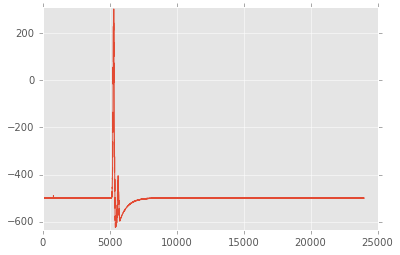

In [53]:
plts(pmtrd, signal_start=0, signal_end=25000, offset=10)

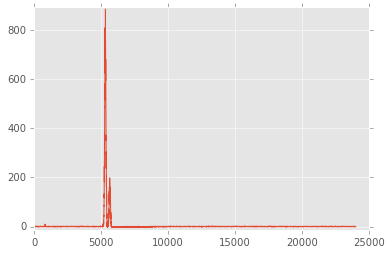

In [54]:
plts(pmtcw, signal_start=0, signal_end=25000, offset=10)

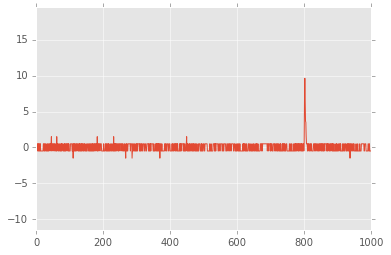

In [56]:
plts(pmtcw, signal_start=0, signal_end=1000, offset=10)

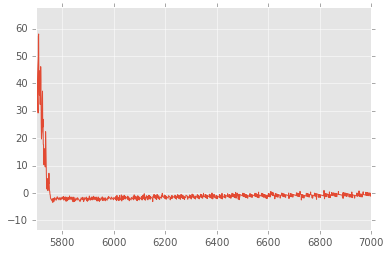

In [60]:
plts(pmtcw, signal_start=5700, signal_end=7000, offset=10)

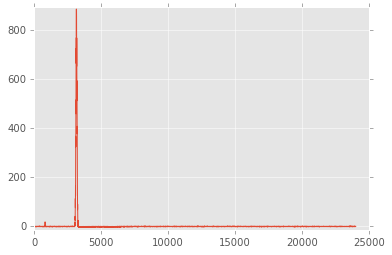

In [61]:
plts(pmtcwf[1, 0], signal_start=0, signal_end=25000, offset=10)

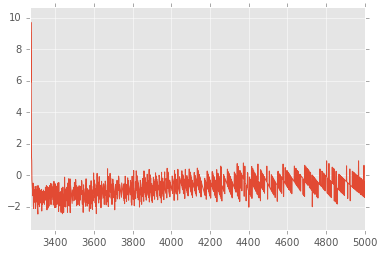

In [71]:
plts(pmtcwf[1, 0], signal_start=3270, signal_end=5000, offset=1)

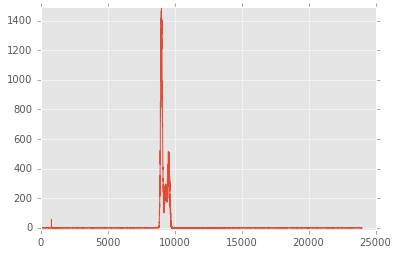

In [72]:
plts(pmtcwf[2, 0], signal_start=0, signal_end=25000, offset=10)

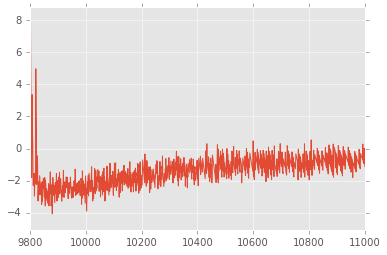

In [78]:
plts(pmtcwf[2, 0], signal_start=9800, signal_end=11000, offset=1)

In [80]:
baseline = h5f.root.BLR.baseline

In [81]:
print(baseline[0])

[-499.4960022  -499.52398682 -499.56399536 -499.48400879 -499.51998901
 -499.56799316 -499.54800415 -499.53601074 -499.49200439 -499.54400635
 -499.45999146 -499.54800415]


In [82]:
h5f.close()

#### thr1 = 5 x sigma, thr2 = 1 x sigma, thr3 = 1 xsigma

In [111]:
%less ../../Config/ISIDORA_NA_ZLIB_test2.csv

In [112]:
ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

INFO:root:Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'AC': '0.0017643 0.00170883 0.00175343 0.0017099 0.00168862 0.00174429 0.0017206 0.00171095 0.00171778 0.00168723 0.00171486 0.00168533', 'LAST_EVT': 10, 'COEF': 1, 'CA': '6.02975448 6.22547194 6.0671337 6.22159457 6.29999787 6.09892384 6.18289435 6.21775591 6.19306671 6.30518792 6.20359891 6.312311921', 'MAU_LEN': 250, 'END ': 1, 'NSIGMA2': 1.0, 'NSIGMA3': 1.0, 'NSIGMA1': 5.0, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'FILE_IN': 'WF_Na_ZLIB_offset500_RWF.h5'}


Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'AC': '0.0017643 0.00170883 0.00175343 0.0017099 0.00168862 0.00174429 0.0017206 0.00171095 0.00171778 0.00168723 0.00171486 0.00168533', 'LAST_EVT': 10, 'COEF': 1, 'CA': '6.02975448 6.22547194 6.0671337 6.22159457 6.29999787 6.09892384 6.18289435 6.21775591 6.19306671 6.30518792 6.20359891 6.312311921', 'MAU_LEN': 250, 'END ': 1, 'NSIGMA2': 1.0, 'NSIGMA3': 1.0, 'NSIGMA1': 5.0, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'FILE_IN': 'WF_Na_ZLIB_offset500_RWF.h5'}



        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST 

        4. Computes the energy of the PMTs per each event and writes to DST

        
Debug level = INFO
INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_offset500_RWF.h5 


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_offset500_RWF.h5 


INFO:root:first event = 0 last event = 10 nof events requested = 10 


first event = 0 last event = 10 nof events requested = 10 


INFO:root:MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 1.0 n_sigma3 = 1.0 


MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 1.0 n_sigma3 = 1.0 


INFO:root:CA sigma(nf) = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192]  


CA sigma(nf) = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192]  


INFO:root:nof PMTs = 12 nof events in input DST = 10 


nof PMTs = 12 nof events in input DST = 10 


INFO:root:lof PMT WF (MC) = 24000 


lof PMT WF (MC) = 24000 


INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


Leaving Isidora. Safe travels!


In [84]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+") 

In [86]:
pmtcwf = h5f.root.RD.pmtcwf

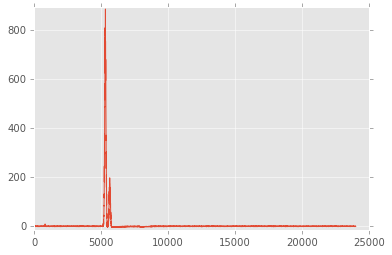

In [87]:
plts(pmtcwf[0, 0], signal_start=0, signal_end=25000, offset=10)

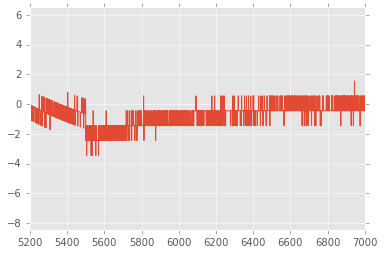

In [95]:
plts(pmtcwf[1, 0], signal_start=5200, signal_end=7000, offset=5)

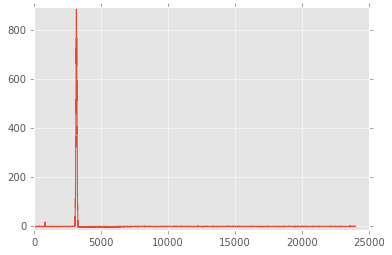

In [96]:
plts(pmtcwf[1, 0], signal_start=0, signal_end=25000, offset=10)

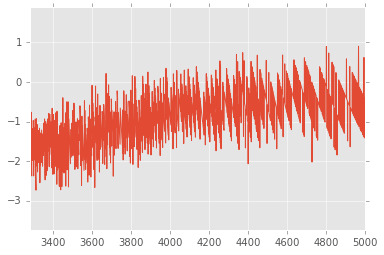

In [98]:
plts(pmtcwf[1, 0], signal_start=3280, signal_end=5000, offset=1)

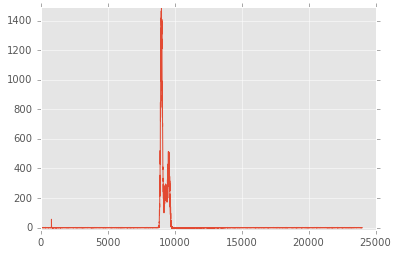

In [99]:
plts(pmtcwf[2, 0], signal_start=0, signal_end=25000, offset=10)

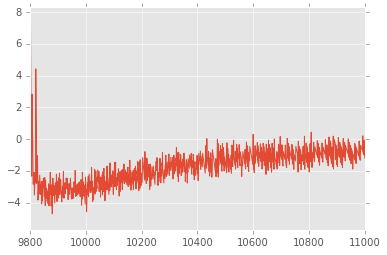

In [100]:
plts(pmtcwf[2, 0], signal_start=9800, signal_end=11000, offset=1)

#### thr1 = 3 x sigma, thr2 = 1 x sigma, thr3 = 2 xsigma

In [101]:
%less ../../Config/ISIDORA_NA_ZLIB_test2.csv

In [102]:
ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

INFO:root:Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'AC': '0.0017643 0.00170883 0.00175343 0.0017099 0.00168862 0.00174429 0.0017206 0.00171095 0.00171778 0.00168723 0.00171486 0.00168533', 'LAST_EVT': 10, 'COEF': 1, 'CA': '6.02975448 6.22547194 6.0671337 6.22159457 6.29999787 6.09892384 6.18289435 6.21775591 6.19306671 6.30518792 6.20359891 6.312311921', 'MAU_LEN': 250, 'END ': 1, 'NSIGMA2': 1.0, 'NSIGMA3': 2.0, 'NSIGMA1': 3.0, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'FILE_IN': 'WF_Na_ZLIB_offset500_RWF.h5'}


Configuration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'AC': '0.0017643 0.00170883 0.00175343 0.0017099 0.00168862 0.00174429 0.0017206 0.00171095 0.00171778 0.00168723 0.00171486 0.00168533', 'LAST_EVT': 10, 'COEF': 1, 'CA': '6.02975448 6.22547194 6.0671337 6.22159457 6.29999787 6.09892384 6.18289435 6.21775591 6.19306671 6.30518792 6.20359891 6.312311921', 'MAU_LEN': 250, 'END ': 1, 'NSIGMA2': 1.0, 'NSIGMA3': 2.0, 'NSIGMA1': 3.0, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/', 'FILE_IN': 'WF_Na_ZLIB_offset500_RWF.h5'}



        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST 

        4. Computes the energy of the PMTs per each event and writes to DST

        
Debug level = INFO
INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_offset500_RWF.h5 


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_offset500_RWF.h5 


INFO:root:first event = 0 last event = 10 nof events requested = 10 


first event = 0 last event = 10 nof events requested = 10 


INFO:root:MAU length = 250 n_sigma1 = 3.0 n_sigma2 = 1.0 n_sigma3 = 2.0 


MAU length = 250 n_sigma1 = 3.0 n_sigma2 = 1.0 n_sigma3 = 2.0 


INFO:root:CA sigma(nf) = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192]  


CA sigma(nf) = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192]  


INFO:root:nof PMTs = 12 nof events in input DST = 10 


nof PMTs = 12 nof events in input DST = 10 


INFO:root:lof PMT WF (MC) = 24000 


lof PMT WF (MC) = 24000 


INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


Leaving Isidora. Safe travels!


In [109]:
def ana_wf():
    h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+")
    pmtcwf = h5f.root.RD.pmtcwf
    plts(pmtcwf[0, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[0, 0], signal_start=5750, signal_end=7000, offset=1)
    plt.show()
    wait()
    plts(pmtcwf[1, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[1, 0], signal_start=3280, signal_end=5000, offset=1)
    plt.show()
    wait()
    plts(pmtcwf[2, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[2, 0], signal_start=9800, signal_end=11000, offset=1)
    plt.show()
    h5f.close()

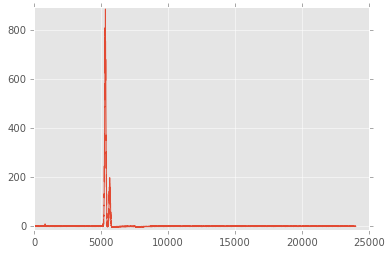

Press a key...


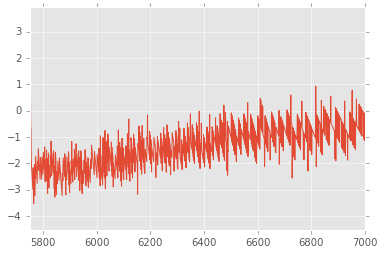

Press a key...


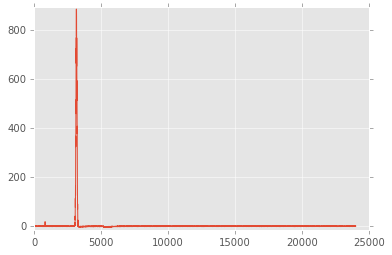

Press a key...


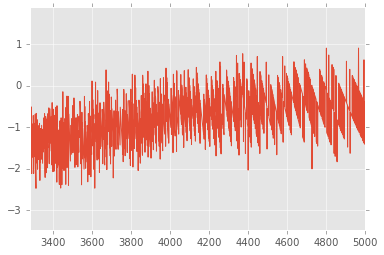

Press a key...


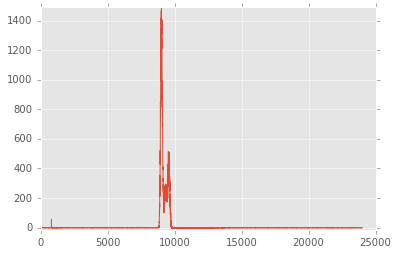

Press a key...


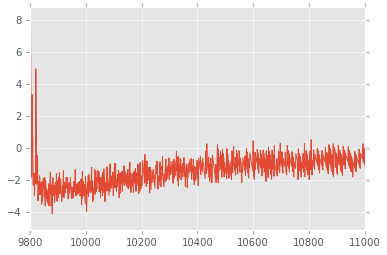

In [110]:
ana_wf()

In [34]:
print(baseline[0])

[-499.4960022  -499.52398682 -499.56399536 -499.48400879 -499.51998901
 -499.56799316 -499.54800415 -499.53601074 -499.49200439 -499.54400635
 -499.45999146 -499.54800415]


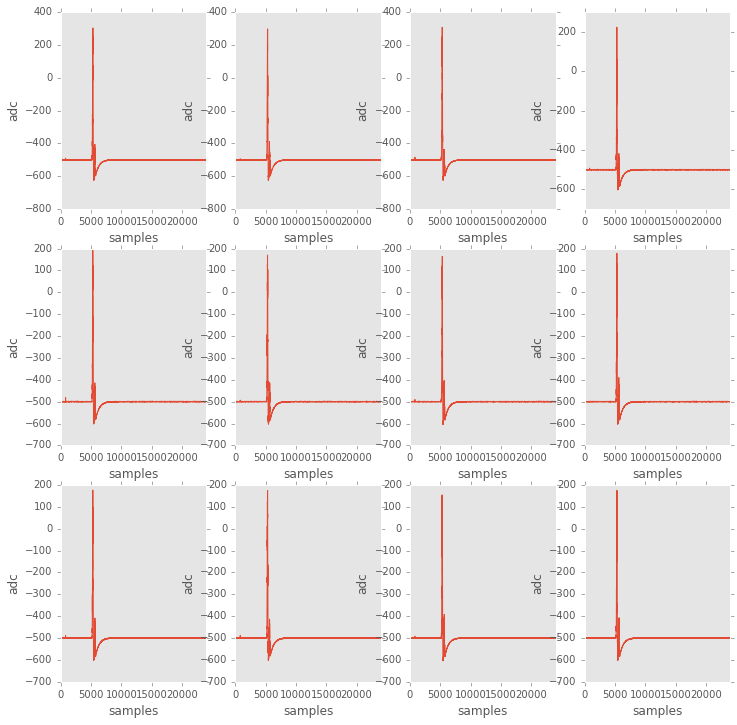

In [35]:
plot_waveforms(pmtrwf[0]) 

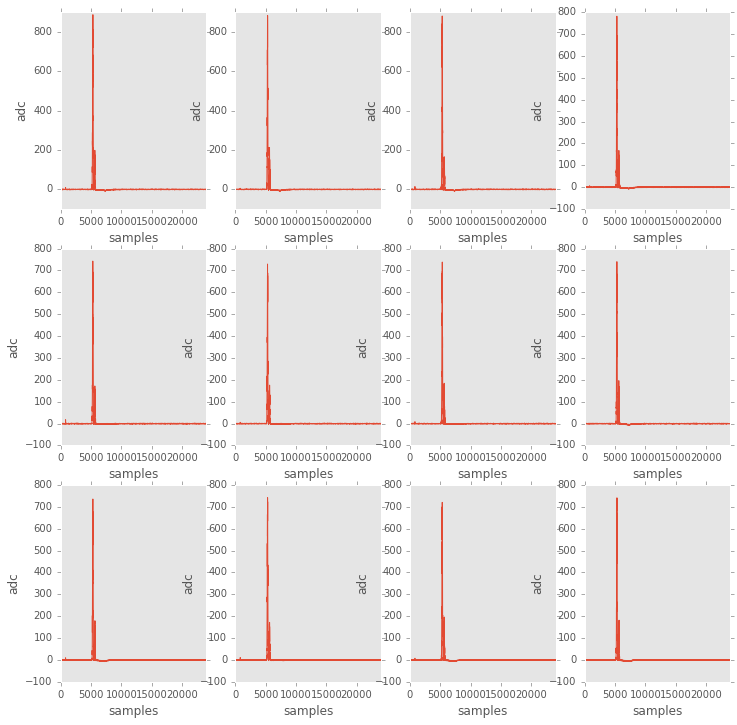

In [36]:
plot_waveforms(pmtcwf[0]) 

In [37]:
h5f.close()